# Basic import

##**Import des packages**

In [ ]:
import numpy as np
import pandas as pd
import io

from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV #recherche meilleures hyperparams
from sklearn.compose import ColumnTransformer # traitement des données
from sklearn.pipeline import Pipeline # automatiser
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler # pour variable caté, et variable nul

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve


from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (roc_auc_score, average_precision_score, accuracy_score,
                             precision_score, recall_score, f1_score,
                             confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


##**Import file**

In [ ]:
from google.colab import files
uploaded = files.upload ()

Saving Camp_Market_Clean_2025.csv to Camp_Market_Clean_2025.csv


In [ ]:
path = "/content/Camp_Market_Clean_2025.csv"

df = pd.read_csv(path, sep=';', encoding='utf-8', low_memory=False)
print("Fichier chargé :", path)
print("Shape :", df.shape)
display(df.head())

Fichier chargé : /content/Camp_Market_Clean_2025.csv
Shape : (2018, 37)


,ID,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,Age,Tenure,TotalMnt,TotalPurchases,AcceptedCmpTotal,Children,Is_Parent,Anciennete_mois,NumWebPurchasesMonth,Taux_conversion_web
0,5524,Graduation,Single,58138.0,0,0,58,635,88,546,...,68,4502,1617,25,0,0,0,147.9,0.054091,0.77
1,2174,Graduation,Single,46344.0,1,1,38,11,1,6,...,71,3952,27,6,0,2,1,129.8,0.007704,0.15
2,4141,Graduation,Together,71613.0,0,0,26,426,49,127,...,60,4151,776,21,0,0,0,136.4,0.058651,1.47
3,6182,Graduation,Together,26646.0,1,0,26,11,4,20,...,41,3978,53,8,0,1,1,130.7,0.015302,0.26
4,5324,PhD,Married,58293.0,1,0,94,173,43,118,...,44,4000,422,19,0,1,1,131.4,0.038052,0.76


# Traitement

## **A)Cible**

In [ ]:
# prépa fichier
df_work = df.copy()

# On définit directement la colonne cible
TARGET_COL = "Response"

# On crée la variable y (déjà propre, sans NaN, déjà en 0/1)
y = df_work[TARGET_COL].astype('int8').to_numpy()

# Vérification de la taille et de la répartition des classes
pos = int(y.sum())
neg = len(y) - pos

#print
print(
    f"La cible est intitulée : {TARGET_COL}\n"
    f" -> Nb positifs : {pos} ({pos/len(y):.1%})\n"
    f" -> Nb négatifs : {neg} ({neg/len(y):.1%})\n"
    f" -> Nb total    : {len(y)}"
)



La cible est intitulée : Response
 -> Nb positifs : 310 (15.4%)
 -> Nb négatifs : 1708 (84.6%)
 -> Nb total    : 2018


La cible est bien trouvée, seulement nous voyons ici que les données sont mal équilibrée.

classes très déséquilibrées (≈ 1 pour 9)
Nous allons donc y remédier.

## **B)Feature engineering**

In [ ]:
print("Vérification des features engineering :")
expected_features = [
    'nb_enfants','Nb_personnes_foyer','Age','Anciennete_mois',
    'TotalMnt','TotalPurchases','NumWebPurchasesMonth','Taux_conversion_web'
]

for feature_name in expected_features:
    print(f" - {feature_name:<25}  {'OK' if feature_name in df_work.columns else 'Manquante'}") # {valeur : [alignement][largeur]}



Vérification des features engineering :
 - nb_enfants                 OK
 - Nb_personnes_foyer         OK
 - Age                        OK
 - Anciennete_mois            OK
 - TotalMnt                   OK
 - TotalPurchases             OK
 - NumWebPurchasesMonth       OK
 - Taux_conversion_web        OK


Ici on vérifie que toutes les features engineering soient bien présentes.

## **C)X/y + split**

In [ ]:
# 1) On retire UNIQUEMENT la cible et la colonne ID de X
id_cols = ['ID'] if 'ID' in df_work.columns else []
X = df_work.drop(columns=[TARGET_COL] + id_cols).copy()

# 2) Split 70/30, STRATIFIÉ (même % de y=1 en train et test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# 3) On garde les ID de côté pour rattacher les prédictions plus tard (sans les utiliser pour entraîner)
id_train = df_work.loc[X_train.index, 'ID'] if 'ID' in df_work.columns else None
id_test  = df_work.loc[X_test.index,  'ID'] if 'ID' in df_work.columns else None


print(f"Train: {X_train.shape} | Test: {X_test.shape}")
print(f"y=1 (a savoir les répondants des campagnes) — Train: {y_train.mean():.2%} | Test: {y_test.mean():.2%}")
if id_cols: #verif si liste existe (vide ou non)
    print("Colonnes ID exclues :", id_cols)

Train: (1412, 35) | Test: (606, 35)
y=1 (a savoir les répondants des campagnes) — Train: 15.37% | Test: 15.35%
Colonnes ID exclues : ['ID']


## **D) Prétraitements**

In [ ]:
# 1) Séparation variables numériques / catégorielles
num_cols = [c for c in X_train.columns if is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if c not in num_cols]
print(f" - Colonnes détectées : num={len(num_cols)} | cat={len(cat_cols)}")

# 2) Pipelines de prétraitement
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32) #on ignore les nouvelles col, on sparse (on garde que les 1), 32 bits = plus rapide)

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  ohe)
])

# 3) Assemblage des transformations
transformers = []
if num_cols:
    transformers.append(("num", numeric_pipe, num_cols))
if cat_cols:
    transformers.append(("cat", categorical_pipe, cat_cols))

preprocess = ColumnTransformer(
    transformers=transformers,
    remainder="drop", #supp col non cité
    sparse_threshold=0.0
)

print(" - Préprocesseur prêt : numériques et catégorielles assemblés.")


 - Colonnes détectées : num=33 | cat=2
 - Préprocesseur prêt : numériques et catégorielles assemblés.


Ce bloc identifie d’abord les colonnes numériques et catégorielles du jeu d’entraînement (ici, 33 numériques et 2 catégorielles).

Il prépare ensuite deux chaînes de traitement :

– pour les variables numériques, remplacement des valeurs manquantes et mise à l’échelle ;

– pour les variables catégorielles, remplacement des valeurs manquantes et encodage en 0/1 via le OneHotEncoder.

Enfin, le ColumnTransformer assemble ces deux pipelines dans un préprocesseur unique, prêt à être utilisé pour l’entraînement des modèles.

## **E) Modèle : régression logistique + GridSearchCV (F1)**

In [ ]:
# Active SMOTE dans le pipeline
USE_SMOTE_IN_PIPELINE = True
if USE_SMOTE_IN_PIPELINE :
    pipe_lr = ImbPipeline(steps=[
        ('prep', preprocess),                               # impute + scale + OHE (dense)
        ('smote', SMOTE(random_state=42, k_neighbors=5)),   # équilibrage SEULEMENT en train, dans chaque fold
        ('clf', LogisticRegression(
            solver='saga',
            max_iter=5000,
            class_weight=None,     # pas de double correction quand SMOTE est actif
            random_state=42
        ))
    ])
else:
    # Baseline : sans SMOTE, on compense côté modèle
    pipe_lr = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', LogisticRegression(
            solver='saga',
            max_iter=5000,
            class_weight='balanced',   # pondération auto sur classes déséquilibrées
            random_state=42
        ))
    ])

# CV stratifiée (cohérente avec ton split)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grille compacte et pertinente (L1/L2/ElasticNet ; l1_ratio uniquement pour elasticnet)
param_grid = [
    {'clf__penalty': ['l1','l2'], 'clf__C': [0.01, 0.1, 1.0, 3.0], 'clf__l1_ratio': [None]},
    {'clf__penalty': ['elasticnet'], 'clf__C': [0.01, 0.1, 1.0, 3.0], 'clf__l1_ratio': [0.0, 0.5]}
]

grid = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    scoring='f1',         # objectif métier : capter la classe 1 sans explosion de FP
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid.fit(X_train, y_train)   # on passe le TRAIN brut : le pipeline gère tout (prep + SMOTE éventuel + clf)
pipe_lr_best = grid.best_estimator_
print(("Meilleurs hyperparamètres LR+SMOTE:" if USE_SMOTE_IN_PIPELINE else "Meilleurs hyperparamètres LR:"),
      grid.best_params_, f"| F1_CV={grid.best_score_:.3f}")


Meilleurs hyperparamètres LR+SMOTE: {'clf__C': 0.1, 'clf__l1_ratio': None, 'clf__penalty': 'l1'} | F1_CV=0.578


## **F) Évaluation test + seuil optimal F1**

[TEST] AUC ROC = 0.905 | Average Precision (PR-AUC) = 0.659


<Figure size 682x594 with 0 Axes>

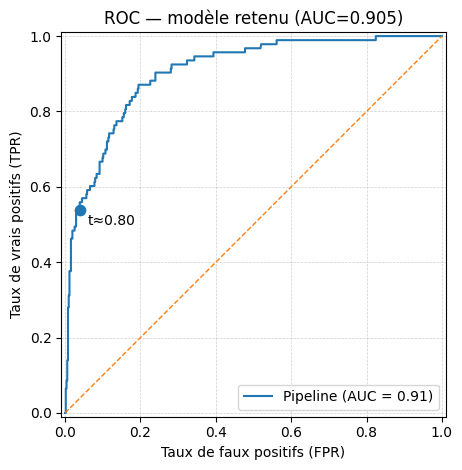

<Figure size 682x594 with 0 Axes>

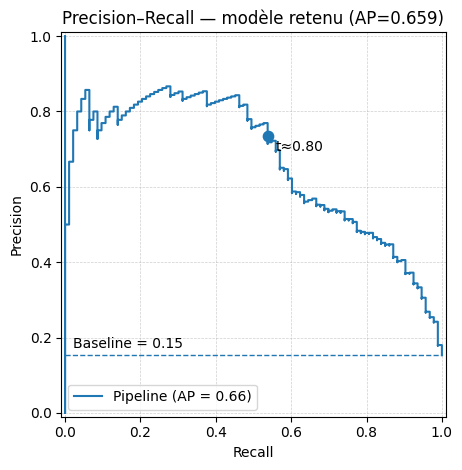

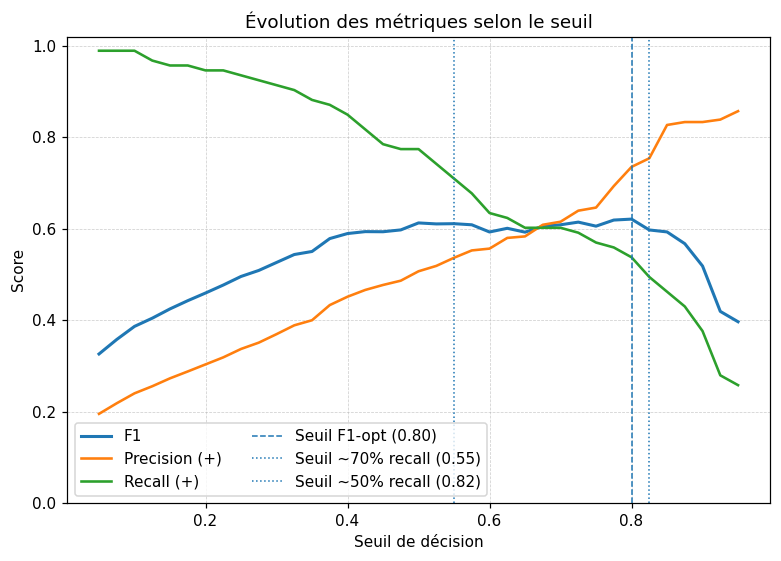


[Seuil F1-optimal] t = 0.80
F1=0.621 | Precision=0.735 | Recall=0.538 | Accuracy=0.899
Confusion matrix [[TN FP],[FN TP]] = [[495 18],[43 50]]


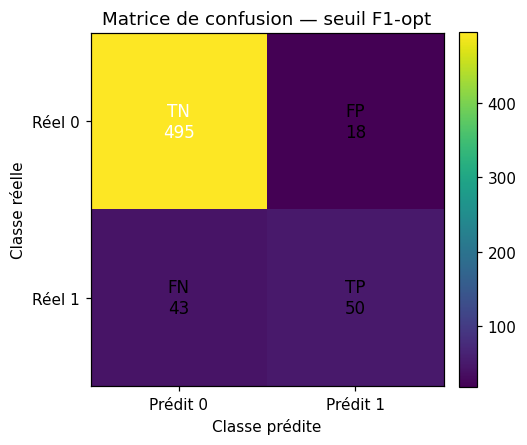


=== Résumé opérationnel (au seuil F1-opt) ===
- Clients ciblés (positifs prédits) : 68
- Répondants captés parmi les ciblés : 50  (Precision ≈ 74%)
- Répondants manqués : 43  (à arbitrer selon le budget vs. rappel)
- Idée d'usage : cibler t ≥ 0.80 puis ajuster le seuil selon la contrainte de budget.


In [ ]:
# 0) Probabilités test + scores agrégés

proba_test = pipe_lr_best.predict_proba(X_test)[:, 1]
AUC = roc_auc_score(y_test, proba_test)
AP  = average_precision_score(y_test, proba_test)  # PR-AUC

print(f"[TEST] AUC ROC = {AUC:.3f} | Average Precision (PR-AUC) = {AP:.3f}")


# 1) Courbe ROC (avec diagonale de hasard + annotation du seuil F1-opt)
# Balayage des seuils pour trouver le F1-optimal
ts = np.linspace(0.05, 0.95, 37)
f1s, precs, recs = [], [], []
for t in ts:
    y_hat = (proba_test >= t).astype(int)
    f1s.append(f1_score(y_test, y_hat, pos_label=1, zero_division=0))
    precs.append(precision_score(y_test, y_hat, pos_label=1, zero_division=0))
    recs.append(recall_score(y_test, y_hat, pos_label=1, zero_division=0))

best_idx = int(np.argmax(f1s))
best_t   = float(ts[best_idx])
best_f1  = float(f1s[best_idx])

# Points ROC/PR “théoriques” pour annoter le point du meilleur seuil
fpr, tpr, thr_roc = roc_curve(y_test, proba_test)                  # thr_roc triés décroissants
prec_curve, rec_curve, thr_pr = precision_recall_curve(y_test, proba_test)
# Trouver l’index du seuil ROC le plus proche de best_t
idx_roc = int(np.argmin(np.abs(thr_roc - best_t))) if len(thr_roc) > 0 else None

plt.figure(figsize=(6.2,5.4), dpi=110)
RocCurveDisplay.from_estimator(pipe_lr_best, X_test, y_test)
plt.plot([0,1], [0,1], linestyle="--", linewidth=1)  # hasard
if idx_roc is not None and 0 <= idx_roc < len(fpr):
    plt.scatter(fpr[idx_roc], tpr[idx_roc], s=55)
    plt.text(fpr[idx_roc]+0.02, tpr[idx_roc]-0.04, f"t≈{best_t:.2f}", fontsize=10)
plt.title(f"ROC — modèle retenu (AUC={AUC:.3f})")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


# 2) Courbe Precision–Recall (avec baseline et annotation du seuil F1-opt)

# Baseline = prévalence positive (utile pour lire PR correctement)
pos_rate = float(np.mean(y_test))

plt.figure(figsize=(6.2,5.4), dpi=110)
PrecisionRecallDisplay.from_estimator(pipe_lr_best, X_test, y_test)
plt.hlines(pos_rate, 0, 1, linestyles="--", linewidth=1)
plt.text(0.02, pos_rate+0.02, f"Baseline = {pos_rate:.2f}", fontsize=10)
# Annoter le point PR au seuil best_t (approx via le point le + proche en recall)
if len(thr_pr) > 0:
    # thr_pr a une longueur = len(prec_curve)-1; on cherche la proba la + proche de best_t
    idx_pr = int(np.argmin(np.abs(thr_pr - best_t)))
    idx_pr = np.clip(idx_pr, 0, len(prec_curve)-1)
    plt.scatter(rec_curve[idx_pr], prec_curve[idx_pr], s=55)
    plt.text(rec_curve[idx_pr]+0.02, prec_curve[idx_pr]-0.04, f"t≈{best_t:.2f}", fontsize=10)

plt.title(f"Precision–Recall — modèle retenu (AP={AP:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()


# 3) Métriques vs seuil (F1 / Precision / Recall) + repères métier

def _closest_threshold(target_recall):
    diffs = [abs(r - target_recall) for r in recs]
    return float(ts[int(np.argmin(diffs))])

t_high_recall = _closest_threshold(0.70)  # ex. capter ~70% des positifs
t_mid_recall  = _closest_threshold(0.50)

plt.figure(figsize=(7.2,5.2), dpi=110)
plt.plot(ts, f1s,   label="F1", linewidth=2)
plt.plot(ts, precs, label="Precision (+)", linewidth=1.7)
plt.plot(ts, recs,  label="Recall (+)", linewidth=1.7)
plt.axvline(best_t, linestyle="--", linewidth=1, label=f"Seuil F1-opt ({best_t:.2f})")
plt.axvline(t_high_recall, linestyle=":", linewidth=1, label=f"Seuil ~70% recall ({t_high_recall:.2f})")
plt.axvline(t_mid_recall, linestyle=":", linewidth=1, label=f"Seuil ~50% recall ({t_mid_recall:.2f})")
plt.title("Évolution des métriques selon le seuil")
plt.xlabel("Seuil de décision")
plt.ylabel("Score")
plt.ylim(0, 1.02)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend(loc="lower left", ncol=2, frameon=True)
plt.tight_layout()
plt.show()


# 4) Bilan chifré au seuil F1-optimal

y_pred = (proba_test >= best_t).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
ACC   = accuracy_score(y_test, y_pred)
PREC1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
REC1  = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

print(f"\n[Seuil F1-optimal] t = {best_t:.2f}")
print(f"F1={best_f1:.3f} | Precision={PREC1:.3f} | Recall={REC1:.3f} | Accuracy={ACC:.3f}")
print(f"Confusion matrix [[TN FP],[FN TP]] = [[{tn} {fp}],[{fn} {tp}]]")

#
# 5) Matrice de confusion — annotations nettes
#
cm = np.array([[tn, fp],
               [fn, tp]], dtype=np.int64)
labels = np.array([["TN","FP"],["FN","TP"]], dtype=object)

plt.figure(figsize=(4.8,4.3), dpi=110)
plt.imshow(cm, interpolation='nearest')
plt.title("Matrice de confusion — seuil F1-opt")
plt.colorbar(fraction=0.046, pad=0.04)
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Prédit 0", "Prédit 1"])
plt.yticks(tick_marks, ["Réel 0", "Réel 1"])
thresh = cm.max() / 2.0
for i in range(2):
    for j in range(2):
        txt = f"{labels[i,j]}\n{cm[i,j]:,}".replace(",", " ")
        plt.text(j, i, txt, ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=11)
plt.ylabel("Classe réelle")
plt.xlabel("Classe prédite")
plt.tight_layout()
plt.show()

#
# 6) Résumé opérationnel (slide métier)
#
nb_contacts = tp + fp
uplift_precision = PREC1
print("\n=== Résumé opérationnel (au seuil F1-opt) ===")
print(f"- Clients ciblés (positifs prédits) : {nb_contacts}")
print(f"- Répondants captés parmi les ciblés : {tp}  (Precision ≈ {uplift_precision:.0%})")
print(f"- Répondants manqués : {fn}  (à arbitrer selon le budget vs. rappel)")
print(f"- Idée d'usage : cibler t ≥ {best_t:.2f} puis ajuster le seuil selon la contrainte de budget.")
best_threshold = best_t


##**G) Entraînement RandomForest seul**

In [ ]:
USE_SMOTE_IN_PIPELINE = True  # cohérent avec ta LR

if USE_SMOTE_IN_PIPELINE:
    pipe_rf = ImbPipeline(steps=[
        ('prep', preprocess),
        ('smote', SMOTE(random_state=42, k_neighbors=5)),
        ('clf', RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            class_weight=None,     # pas de double correction si SMOTE actif
            random_state=42,
            n_jobs=-1
        ))
    ])
else:
    pipe_rf = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features='sqrt',
            class_weight='balanced',  # si pas de SMOTE
            random_state=42,
            n_jobs=-1
        ))
    ])

# Grille RF (compacte)
param_grid_rf = {
    'clf__n_estimators': [300, 400, 600],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid_rf.fit(X_train, y_train)
rf_best = grid_rf.best_estimator_
print("Meilleurs hyperparamètres RF:", grid_rf.best_params_, f"| F1_CV={grid_rf.best_score_:.3f}")


Meilleurs hyperparamètres RF: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__n_estimators': 400} | F1_CV=0.569


##**H) Bench inter-modèles — RandomForest vs LogisticRegression**


=== Comparatif modèles (test) — trié par F1* puis PR-AUC puis AUC ===
            Modèle      AUC   PR-AUC      F1*  Precision   Recall  Seuil*
LogisticRegression 0.905374 0.659438 0.621118   0.735294 0.537634    0.80
      RandomForest 0.892211 0.611214 0.585366   0.535714 0.645161    0.45


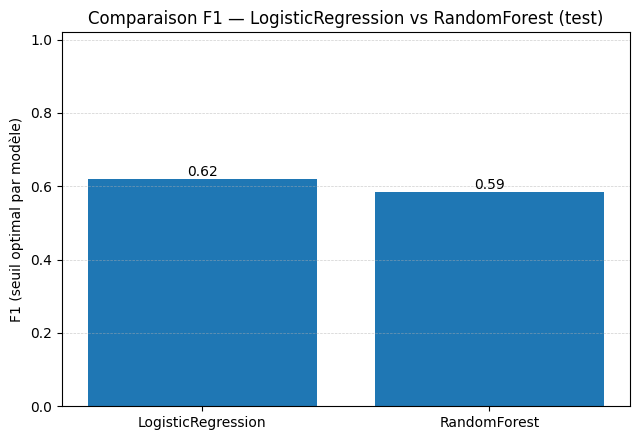


→ Modèle recommandé : **LogisticRegression** (F1=0.621, PR-AUC=0.659, AUC=0.905, seuil≈0.80)


In [ ]:
# 1) Regroupe les meilleurs pipelines
best_estimators = {
    "LogisticRegression": pipe_lr_best,   # issu de ton bloc E
    "RandomForest": rf_best               # issu du bloc G
}

# 2) Évaluation commune (AUC, PR-AUC, F1 au seuil optimal par modèle)
def eval_model(name, model, X_te, y_te):
    proba = model.predict_proba(X_te)[:, 1]
    auc  = roc_auc_score(y_te, proba)
    ap   = average_precision_score(y_te, proba)

    ts = np.linspace(0.05, 0.95, 37)  # grille simple de seuils
    f1s = []
    for t in ts:
        y_hat = (proba >= t).astype(int)
        f1s.append(f1_score(y_te, y_hat, zero_division=0))
    best_idx = int(np.argmax(f1s))
    best_t   = float(ts[best_idx])
    y_hat    = (proba >= best_t).astype(int)

    prec = precision_score(y_te, y_hat, zero_division=0)
    rec  = recall_score(y_te, y_hat, zero_division=0)

    return {
        "Modèle": name,
        "Estimator": model,
        "AUC": auc,
        "PR-AUC": ap,
        "F1*": float(f1s[best_idx]),
        "Precision": float(prec),
        "Recall": float(rec),
        "Seuil*": best_t
    }

# 3) Run & tableau comparatif
results = [eval_model(name, est, X_test, y_test) for name, est in best_estimators.items()]
bench = pd.DataFrame(results).sort_values(['F1*','PR-AUC','AUC'], ascending=False).reset_index(drop=True)

print("\n=== Comparatif modèles (test) — trié par F1* puis PR-AUC puis AUC ===")
print(bench[['Modèle','AUC','PR-AUC','F1*','Precision','Recall','Seuil*']].to_string(index=False))

# 4) Visualisation rapide — F1 par modèle
plt.figure(figsize=(6.5,4.5))
x = np.arange(len(bench))
plt.bar(x, bench['F1*'].values)
plt.xticks(x, bench['Modèle'], rotation=0)
plt.ylabel("F1 (seuil optimal par modèle)")
plt.title("Comparaison F1 — LogisticRegression vs RandomForest (test)")
for i,v in enumerate(bench['F1*'].values):
    plt.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)
plt.ylim(0, 1.02)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout(); plt.show()

# 5) Verdict & objets pour usage ultérieur
best_row = bench.iloc[0]
best_name = best_row['Modèle']
print(f"\n→ Modèle recommandé : **{best_name}** "
      f"(F1={best_row['F1*']:.3f}, PR-AUC={best_row['PR-AUC']:.3f}, AUC={best_row['AUC']:.3f}, seuil≈{best_row['Seuil*']:.2f})")

best_model_overall = best_estimators[best_name]
best_threshold_overall = float(best_row['Seuil*'])
